<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span>Import Necessaries</b>

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer
import wandb

<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> EDA + Vis</b>

<a id="3.1"></a>
### <b>3.1 <span style='color:#B21010'>||</span> Load the data</b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import transformers
import pandas as pd

df =  pd.read_csv('/content/drive/My Drive/API-Dokumentation-generate-tag.csv')
df

,tag,question,answer
0,fact-1,Tolong berikan informasi mengenai Pokemon Acce...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
1,fact-1,Bisa jelaskan secara detail tentang Pokemon Ac...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
2,fact-1,Mohon dijelaskan tentang Pokemon Accelgor.,https://api.pokemontcg.io/v2/cards?q=!name:acc...
3,fact-1,Apa yang bisa Anda ceritakan tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
4,fact-1,Saya ingin tahu lebih banyak tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
...,...,...,...
2490,fact-125,Apakah terdapat laporan tentang tren investasi...,https://api-berita-indonesia.vercel.app/cnbc/t...
2491,fact-125,Bagaimana liputan tersebut mempertimbangkan pe...,https://api-berita-indonesia.vercel.app/cnbc/t...
2492,fact-125,Apakah ada analisis atau diskusi tentang perke...,https://api-berita-indonesia.vercel.app/cnbc/t...
2493,fact-125,Bagaimana pandangan para ahli tentang masa dep...,https://api-berita-indonesia.vercel.app/cnbc/t...


<a id="3.2"></a>
### <b>3.2 <span style='color:#B21010'>||</span> Extract Info from the Json data file and Store it in dataframe</b>

In [ ]:
df2 = df.copy()
df2.head()

,tag,question,answer
0,fact-1,Tolong berikan informasi mengenai Pokemon Acce...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
1,fact-1,Bisa jelaskan secara detail tentang Pokemon Ac...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
2,fact-1,Mohon dijelaskan tentang Pokemon Accelgor.,https://api.pokemontcg.io/v2/cards?q=!name:acc...
3,fact-1,Apa yang bisa Anda ceritakan tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
4,fact-1,Saya ingin tahu lebih banyak tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...


<a id="3.3"></a>
### <b>3.3 <span style='color:#B21010'>||</span> Check the shape of the dataset</b>

In [ ]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 2495 rows and 3 columns


<a id="3.4"></a>
### <b>3.4 <span style='color:#B21010'>||</span> Display information about the dataset</b>

In [ ]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag       2495 non-null   object
 1   question  2495 non-null   object
 2   answer    2495 non-null   object
dtypes: object(3)
memory usage: 58.6+ KB
None


<a id="3.5"></a>
### <b>3.5 <span style='color:#B21010'>||</span> Display Number of Classes</b>

In [ ]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'tag', "Chatbot")

The Chatbot dataset has 125 classes


<a id="3.6"></a>
### <b>3.6 <span style='color:#B21010'>||</span> Check the null values in the dataset</b>

In [ ]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

tag         0
question    0
answer      0
dtype: int64


<a id="3.7"></a>
### <b>3.7 <span style='color:#B21010'>||</span> Visualize the Null Values</b>

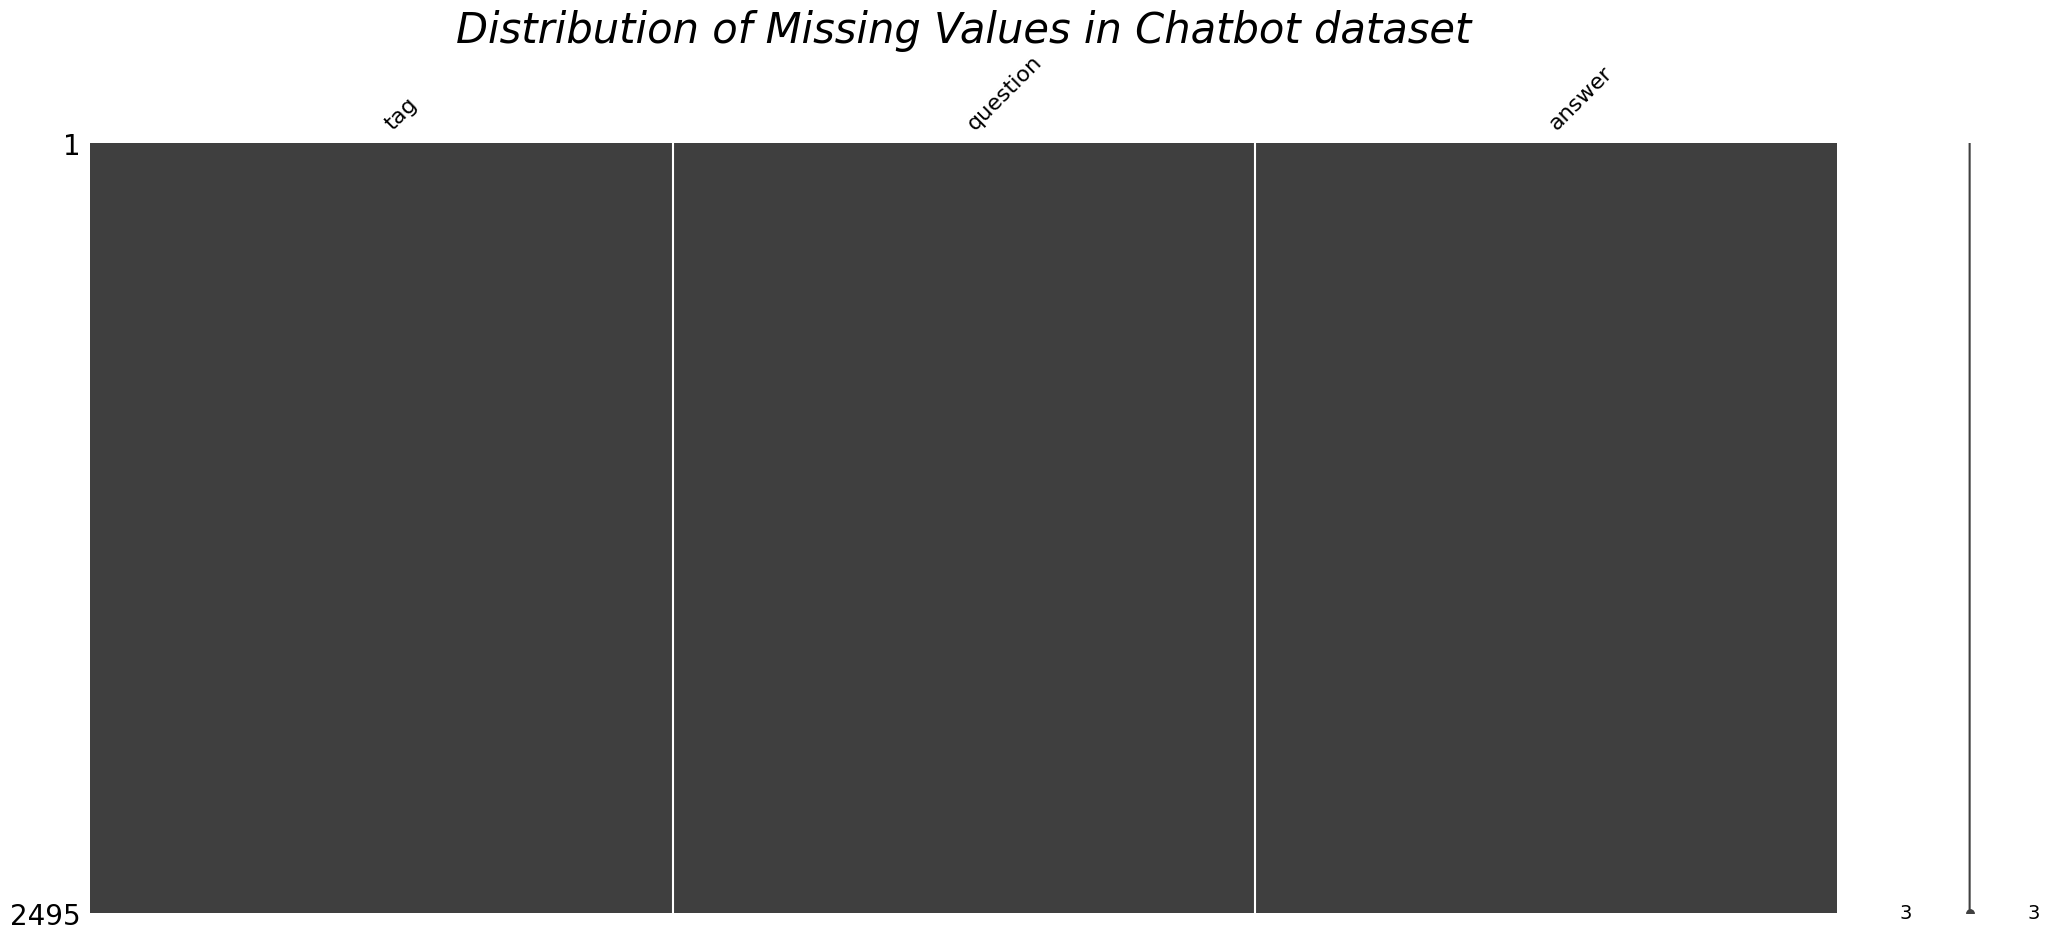

In [ ]:
import missingno as msno
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

In [ ]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [ ]:
df.head()

,tag,question,answer
0,fact-1,Tolong berikan informasi mengenai Pokemon Acce...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
1,fact-1,Bisa jelaskan secara detail tentang Pokemon Ac...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
2,fact-1,Mohon dijelaskan tentang Pokemon Accelgor.,https://api.pokemontcg.io/v2/cards?q=!name:acc...
3,fact-1,Apa yang bisa Anda ceritakan tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...
4,fact-1,Saya ingin tahu lebih banyak tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...


<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> Data Preprocessing</b>

In [ ]:
df2.head()

,Pattern,Tag
0,Halo,sapaan
1,Selamat pagi,sapaan
2,Selamat siang,sapaan
3,Selamat sore,sapaan
4,Selamat malam,sapaan


In [ ]:
labels = df['answer'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['https://api.pokemontcg.io/v2/cards?q=!name:accelgor',
 'https://api.pokemontcg.io/v2/cards?q=!name:araquanid',
 'https://api.pokemontcg.io/v2/cards?q=!name:appletun',
 'https://api.pokemontcg.io/v2/cards?q=!name:ariados',
 'https://api.pokemontcg.io/v2/cards?q=!name:smoliv',
 'https://api.pokemontcg.io/v2/cards?q=!name:varoom',
 'https://api.pokemontcg.io/v2/cards?q=!name:flygon',
 'https://api.pokemontcg.io/v2/cards?q=!name:kyurem',
 'https://api.pokemontcg.io/v2/cards?q=!name:mawile',
 'https://api.pokemontcg.io/v2/cards?q=!name:cobalion',
 'https://api.pokemontcg.io/v2/cards?q=!name:zygarde',
 'https://api.pokemontcg.io/v2/cards?q=!name:registeel',
 'https://api.pokemontcg.io/v2/cards?q=!name:oddish',
 'https://api.pokemontcg.io/v2/cards?q=!name:salamence',
 'https://api.pokemontcg.io/v2/cards?q=!name:latios',
 'https://api.pokemontcg.io/v2/cards?q=!name:magneton',
 'https://api.pokemontcg.io/v2/cards?q=!name:snivy',
 'https://api.pokemontcg.io/v2/cards?q=!name:genesect',
 'https:

In [ ]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [ ]:
id2label

{0: 'https://api.pokemontcg.io/v2/cards?q=!name:accelgor',
 1: 'https://api.pokemontcg.io/v2/cards?q=!name:araquanid',
 2: 'https://api.pokemontcg.io/v2/cards?q=!name:appletun',
 3: 'https://api.pokemontcg.io/v2/cards?q=!name:ariados',
 4: 'https://api.pokemontcg.io/v2/cards?q=!name:smoliv',
 5: 'https://api.pokemontcg.io/v2/cards?q=!name:varoom',
 6: 'https://api.pokemontcg.io/v2/cards?q=!name:flygon',
 7: 'https://api.pokemontcg.io/v2/cards?q=!name:kyurem',
 8: 'https://api.pokemontcg.io/v2/cards?q=!name:mawile',
 9: 'https://api.pokemontcg.io/v2/cards?q=!name:cobalion',
 10: 'https://api.pokemontcg.io/v2/cards?q=!name:zygarde',
 11: 'https://api.pokemontcg.io/v2/cards?q=!name:registeel',
 12: 'https://api.pokemontcg.io/v2/cards?q=!name:oddish',
 13: 'https://api.pokemontcg.io/v2/cards?q=!name:salamence',
 14: 'https://api.pokemontcg.io/v2/cards?q=!name:latios',
 15: 'https://api.pokemontcg.io/v2/cards?q=!name:magneton',
 16: 'https://api.pokemontcg.io/v2/cards?q=!name:snivy',
 17: '

In [ ]:
label2id

{'https://api.pokemontcg.io/v2/cards?q=!name:accelgor': 0,
 'https://api.pokemontcg.io/v2/cards?q=!name:araquanid': 1,
 'https://api.pokemontcg.io/v2/cards?q=!name:appletun': 2,
 'https://api.pokemontcg.io/v2/cards?q=!name:ariados': 3,
 'https://api.pokemontcg.io/v2/cards?q=!name:smoliv': 4,
 'https://api.pokemontcg.io/v2/cards?q=!name:varoom': 5,
 'https://api.pokemontcg.io/v2/cards?q=!name:flygon': 6,
 'https://api.pokemontcg.io/v2/cards?q=!name:kyurem': 7,
 'https://api.pokemontcg.io/v2/cards?q=!name:mawile': 8,
 'https://api.pokemontcg.io/v2/cards?q=!name:cobalion': 9,
 'https://api.pokemontcg.io/v2/cards?q=!name:zygarde': 10,
 'https://api.pokemontcg.io/v2/cards?q=!name:registeel': 11,
 'https://api.pokemontcg.io/v2/cards?q=!name:oddish': 12,
 'https://api.pokemontcg.io/v2/cards?q=!name:salamence': 13,
 'https://api.pokemontcg.io/v2/cards?q=!name:latios': 14,
 'https://api.pokemontcg.io/v2/cards?q=!name:magneton': 15,
 'https://api.pokemontcg.io/v2/cards?q=!name:snivy': 16,
 'http

In [ ]:
df['labels'] = df['answer'].map(lambda x: label2id[x.strip()])
df.head()

,tag,question,answer,labels
0,fact-1,Tolong berikan informasi mengenai Pokemon Acce...,https://api.pokemontcg.io/v2/cards?q=!name:acc...,0
1,fact-1,Bisa jelaskan secara detail tentang Pokemon Ac...,https://api.pokemontcg.io/v2/cards?q=!name:acc...,0
2,fact-1,Mohon dijelaskan tentang Pokemon Accelgor.,https://api.pokemontcg.io/v2/cards?q=!name:acc...,0
3,fact-1,Apa yang bisa Anda ceritakan tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...,0
4,fact-1,Saya ingin tahu lebih banyak tentang Pokemon A...,https://api.pokemontcg.io/v2/cards?q=!name:acc...,0


<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span> Split the data into train and test</b>

In [ ]:
X = list(df['question'])
X[:5]

['Tolong berikan informasi mengenai Pokemon Accelgor.',
 'Bisa jelaskan secara detail tentang Pokemon Accelgor?',
 'Mohon dijelaskan tentang Pokemon Accelgor.',
 'Apa yang bisa Anda ceritakan tentang Pokemon Accelgor?',
 'Saya ingin tahu lebih banyak tentang Pokemon Accelgor, bisa dijelaskan?']

In [ ]:
y = list(df['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

<a id="6"></a>
## <b>6 <span style='color:#B21010'>||</span> Load BERT Pretrained model and Tokenizer</b>

In [ ]:
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# model_name = "distilbert-base-uncased"
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


respond text generation

In [ ]:

# from transformers import AutoModelForCausalLM, AutoTokenizer
# # from transformers import BertTokenizer
# model_name = "microsoft/Orca-2-13b"
# max_len = 256
# # model = AutoModelForCausalLM.from_pretrained(
# #     model_name,
# #     quantization_config = bnb_config,
# #     device_map = "auto",
# # )

# tokenizer = AutoTokenizer.from_pretrained(model_name,
#                                           max_length=max_len)
# model = AutoModelForCausalLM.from_pretrained(model_name,
#                                                       num_labels=num_labels,
#                                                       id2label=id2label,
#                                                       label2id = label2id)


<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span> Transform the data into numerical format</b>

In [ ]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
full_data = tokenizer(X, truncation=True, padding=True)

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span> Build Data Loader</b>


In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span> Define Evaluation Metrcies</b>


In [ ]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="10"></a>
## <b>10 <span style='color:#B21010'>||</span> Define Training Arguments</b>


In [ ]:
pip install transformers[torch]

In [ ]:
pip install accelerate -U

In [ ]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

<a id="11"></a>
## <b>11 <span style='color:#B21010'>||</span> Train the model</b>


In [ ]:
import wandb
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,4.617800,4.456614,0.049679,0.014442,0.013786,0.034457
100,4.286400,4.039071,0.086538,0.046315,0.054168,0.078787
150,3.713600,3.372520,0.216346,0.146702,0.158314,0.211592
200,2.993500,2.730746,0.453526,0.374634,0.365668,0.431905
250,2.365400,2.135447,0.637821,0.570946,0.564835,0.634762
300,1.812700,1.684960,0.711538,0.652405,0.678589,0.699238
350,1.389100,1.325452,0.767628,0.710658,0.717487,0.759464
400,1.032400,1.066805,0.790064,0.742838,0.764353,0.784214
450,0.812000,0.881858,0.825321,0.790107,0.793173,0.823905
500,0.638200,0.748134,0.855769,0.827570,0.840107,0.848651


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=1770, training_loss=0.737635767948156, metrics={'train_runtime': 747.8095, 'train_samples_per_second': 75.059, 'train_steps_per_second': 2.367, 'total_flos': 1905417203960160.0, 'train_loss': 0.737635767948156, 'epoch': 30.0})

<a id="12"></a>
## <b>12 <span style='color:#B21010'>||</span> Evaluate the model</b>


In [ ]:
q=[trainer.evaluate(eval_dataset=df) for df in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.033438,0.999466,0.999394,0.999412,0.999412
test,0.372926,0.902244,0.884918,0.895349,0.891825


In [ ]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
text = "saya gk tau pokemon air"
predict(text)

(tensor([[7.8617e-05, 1.0223e-04, 4.5760e-04, 5.6350e-04, 1.1829e-03, 3.1545e-04,
          4.0971e-05, 1.0943e-04, 9.3592e-05, 8.3014e-05, 1.0048e-04, 1.4857e-04,
          1.5916e-04, 1.6253e-04, 1.7226e-04, 3.1160e-05, 1.2036e-03, 9.7154e-04,
          2.5753e-04, 9.7029e-01, 2.1336e-04, 9.9152e-04, 1.0258e-04, 2.9547e-04,
          3.5629e-04, 1.5624e-05, 3.4157e-04, 7.9370e-05, 9.9824e-05, 7.1755e-05,
          4.6895e-04, 4.0650e-04, 2.1841e-05, 6.7904e-05, 3.0920e-04, 3.4425e-05,
          1.4866e-05, 1.4375e-04, 8.3102e-05, 1.6598e-05, 3.3771e-04, 7.9942e-05,
          3.2269e-05, 4.3419e-05, 8.2208e-05, 4.1726e-05, 7.0038e-05, 8.0061e-05,
          1.2798e-04, 6.4890e-04, 2.7424e-04, 2.2708e-04, 2.5835e-04, 6.2871e-04,
          3.4617e-04, 4.7432e-04, 1.0942e-03, 2.0661e-04, 6.2024e-05, 5.0413e-04,
          1.2758e-03, 1.0562e-03, 2.9260e-04, 2.3587e-04, 2.1364e-04, 6.8755e-05,
          6.0530e-05, 2.7234e-04, 4.6626e-04, 4.2463e-05, 1.4048e-05, 3.8152e-04,
          8.2037

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
import torch

In [ ]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [ ]:
# # -*- coding: utf-8 -*-
# """
# From scratch implementation of the famous ResNet models.
# The intuition for ResNet is simple and clear, but to code
# it didn't feel super clear at first, even when reading Pytorch own
# implementation.

# Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
# *    2020-04-12 Initial coding
# *    2022-12-20 Update comments, code revision, checked still works with latest PyTorch version
# """

# import torch
# import torch.nn as nn


# class block(nn.Module):
#     def __init__(
#         self, in_channels, intermediate_channels, identity_downsample=None, stride=1
#     ):
#         super().__init__()
#         self.expansion = 4
#         self.conv1 = nn.Conv2d(
#             in_channels,
#             intermediate_channels,
#             kernel_size=1,
#             stride=1,
#             padding=0,
#             bias=False,
#         )
#         self.bn1 = nn.BatchNorm2d(intermediate_channels)
#         self.conv2 = nn.Conv2d(
#             intermediate_channels,
#             intermediate_channels,
#             kernel_size=3,
#             stride=stride,
#             padding=1,
#             bias=False,
#         )
#         self.bn2 = nn.BatchNorm2d(intermediate_channels)
#         self.conv3 = nn.Conv2d(
#             intermediate_channels,
#             intermediate_channels * self.expansion,
#             kernel_size=1,
#             stride=1,
#             padding=0,
#             bias=False,
#         )
#         self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
#         self.relu = nn.ReLU()
#         self.identity_downsample = identity_downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x.clone()

#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)

#         if self.identity_downsample is not None:
#             identity = self.identity_downsample(identity)

#         x += identity
#         x = self.relu(x)
#         return x


# class ResNet(nn.Module):
#     def __init__(self, block, layers, image_channels, num_classes):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(
#             image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
#         )
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # Essentially the entire ResNet architecture are in these 4 lines below
#         self.layer1 = self._make_layer(
#             block, layers[0], intermediate_channels=64, stride=1
#         )
#         self.layer2 = self._make_layer(
#             block, layers[1], intermediate_channels=128, stride=2
#         )
#         self.layer3 = self._make_layer(
#             block, layers[2], intermediate_channels=256, stride=2
#         )
#         self.layer4 = self._make_layer(
#             block, layers[3], intermediate_channels=512, stride=2
#         )

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * 4, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.reshape(x.shape[0], -1)
#         x = self.fc(x)

#         return x

#     def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
#         identity_downsample = None
#         layers = []

#         # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
#         # we need to adapt the Identity (skip connection) so it will be able to be added
#         # to the layer that's ahead
#         if stride != 1 or self.in_channels != intermediate_channels * 4:
#             identity_downsample = nn.Sequential(
#                 nn.Conv2d(
#                     self.in_channels,
#                     intermediate_channels * 4,
#                     kernel_size=1,
#                     stride=stride,
#                     bias=False,
#                 ),
#                 nn.BatchNorm2d(intermediate_channels * 4),
#             )

#         layers.append(
#             block(self.in_channels, intermediate_channels, identity_downsample, stride)
#         )

#         # The expansion size is always 4 for ResNet 50,101,152
#         self.in_channels = intermediate_channels * 4

#         # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
#         # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
#         # and also same amount of channels.
#         for i in range(num_residual_blocks - 1):
#             layers.append(block(self.in_channels, intermediate_channels))

#         return nn.Sequential(*layers)


# def ResNet50(img_channel=3, num_classes=1000):
#     return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


# def ResNet101(img_channel=3, num_classes=1000):
#     return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


# def ResNet152(img_channel=3, num_classes=1000):
#     return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


# def test():
#     BATCH_SIZE = 4
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     net = ResNet101(img_channel=3, num_classes=1000).to(device)
#     y = net(torch.randn(BATCH_SIZE, 3, 224, 224)).to(device)
#     assert y.size() == torch.Size([BATCH_SIZE, 1000])
#     print(y.size())


# if __name__ == "__main__":
#     test()

<a id="13"></a>
## <b>13 <span style='color:#B21010'>||</span> Save the model</b>


In [ ]:
model_path = "chatbot-generate-api"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot-pdam-generate-api-v2/tokenizer_config.json',
 'chatbot-pdam-generate-api-v2/special_tokens_map.json',
 'chatbot-pdam-generate-api-v2/vocab.txt',
 'chatbot-pdam-generate-api-v2/added_tokens.json')

<a id="14"></a>
## <b>14 <span style='color:#B21010'>||</span> Load the model</b>


In [ ]:
model_path = "chatbot-generate-api"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
chatbot("saya ingin mengetahui pokemon air")

[{'label': 'https://api.pokemontcg.io/v2/cards?q=!types:water',
  'score': 0.9862828850746155}]

<a id="15"></a>
## <b>15 <span style='color:#B21010'>||</span> Chat with the Chatbot</b>


In [ ]:
def chat(chatbot):

    print("Chatbot: Hallo! kami sebuah program yang akan membantu dalam menjawab dan melayani pelanggan pdam, silahkan bertanya dan kami akan melakukan yang terbaik dalam memberi jawaban dan membantu keluhan anda..")
    print("ketik selesai jika ingin mengakhiri percakapant\n\n")

    text = input("User: ").strip().lower()

    while(text != 'selesai'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Maaf, kami belum bisa menjawab pertanyaan anda\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = chatbot(text)[0]

        # print(f"User: {text}\n")
        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [ ]:
chat(chatbot)

Chatbot: Hallo! kami sebuah program yang akan membantu dalam menjawab dan melayani pelanggan pdam, silahkan bertanya dan kami akan melakukan yang terbaik dalam memberi jawaban dan membantu keluhan anda..
ketik selesai jika ingin mengakhiri percakapant


User: pokemon air
Chatbot: {'label': 'https://api.pokemontcg.io/v2/cards?q=!types:water', 'score': 0.9849933385848999}


User: berita politik indonesia
Chatbot: Maaf, kami belum bisa menjawab pertanyaan anda


User: berita antara
Chatbot: Maaf, kami belum bisa menjawab pertanyaan anda


User: apa efek teknologi disektor industri indonesia
Chatbot: Maaf, kami belum bisa menjawab pertanyaan anda


User: infokan pokemon asselgor
Chatbot: {'label': 'https://api.pokemontcg.io/v2/cards?q=!name:accelgor', 'score': 0.9342983365058899}


User: kabar terkini politik indonesia
Chatbot: {'label': 'https://jakpost.vercel.app/api/category/indonesia/politics', 'score': 0.9520431160926819}


User: berita dari sumber cnbc
Chatbot: {'label': 'https://api